In [69]:
import matplotlib.pyplot as plt


if 'thesis.Trajectory' in sys.modules: del sys.modules['thesis.Trajectory']
from thesis.Trajectory import Trajectory

if 'thesis.Aircraft' in sys.modules: del sys.modules['thesis.Aircraft']
from thesis.Aircraft import Aircraft

if 'thesis.Flight' in sys.modules: del sys.modules['thesis.Flight']
from thesis.Flight import Flight

if 'thesis.Scenario' in sys.modules: del sys.modules['thesis.Scenario']
from thesis.Scenario import Scenario

scene = Scenario()
with seed(0):
    scene.addRandomGroundUsersUniformCircular(1, r=1000) 
    
#craft = Aircraft(mass = 40, wingSpan = 5.65, e0 = 0.92, chord = 0.305)
craft = Aircraft(mass = 10, wingSpan = 10, e0 = 0.92, chord = 0.5)


Trajectory([
    [0,0,50,0],
    [100,0,51,0],
    [100,100,50,0],
    [0,100,52,0],
]).render()

Graphics3d Object

In [62]:
if 'thesis.EvalHelper' in sys.modules: del sys.modules['thesis.EvalHelper']
from thesis.EvalHelper import Judge
if 'thesis.Genetics' in sys.modules: del sys.modules['thesis.Genetics']
from thesis.Genetics import Chromosome, GARunner

j = Judge(scene, craft)

runner = GARunner(
    # Number of individuals
    5,
    # Generate new individual
    lambda: j.newChromosome(),
    # Fitness function
    lambda chromo: j.judgeChromosome(chromo)[0],
    # Per-bit probability of mutation in children
    pMutation = 0.05
)

from tqdm.notebook import tqdm

allFitness = []



for gen in tqdm(range(20)):
    fitnesses = runner.iterate(lambda x: tqdm(x, leave=False))
    print('%d, %d, %d, %d min/avg/max/sum kb/J' % (
        min(fitnesses)*1e3,
        sum(fitnesses) / len(fitnesses)*1e3,
        max(fitnesses)*1e3,
        sum(fitnesses)*1e3
    ))
    allFitness.append(fitnesses)
    
score, thru, meanFlightPower, cycleTime, positions, thruPlot = j.judgeChromosome(runner.population[0], dbg=True)
print(score, thru, meanFlightPower, cycleTime)
show(positions)
show(thruPlot)

IndexError: Random weighted select failed with 0.00/0.00

In [35]:
if 'thesis.simulation' in sys.modules: del sys.modules['thesis.simulation']
from ns.core import Vector, MilliSeconds, Seconds, StringValue
from thesis.simulation import SimulationContext
import ns.mobility
from ns.mobility import PathMobilityModelSegments as Seg
import ns.flow_monitor

flh = ns.flow_monitor.FlowMonitorHelper()

with SimulationContext() as sim:
    sim.addEnbFlight(j.chromosomeToFlight(runner.population[0]))
    
    # For testing a straight-away path
    #mobile = ns.mobility.PathMobilityModel()
    #mobile.AddSegment(ns.mobility.PathMobilityModelSegments.LineSegment(ns.core.Vector(2000, 0, 0), ns.core.Vector(10000, 0, 0), 100))
    #sim.enbMobilities.append(mobile)
        
    #sim.addEnbFlight(flight)
    for user in scene.users:
        sim.addUser(*user)
    sim._finalizeNodes()
    
    # Setup traffic gen
    ueNode = sim.ueNodes.Get(0)
    ueNetDev = sim.ueLteDevs.Get(0)
    ueIp = sim.ueIpIface.GetAddress(0)
    
    sinkAddr = ns.network.InetSocketAddress(sim.remoteHostAddr, 9000)
    packetSinkHelper = ns.applications.PacketSinkHelper("ns3::UdpSocketFactory", sinkAddr)
    sim.serverApps.Add(packetSinkHelper.Install(sim.remoteHost))
    
    h = ns.applications.PPBPHelper("ns3::UdpSocketFactory", sinkAddr)
    # Supposed to be how many active "bursts" we have, but appears to be how many started per second
    h.SetAttribute("MeanBurstArrivals", StringValue("ns3::ConstantRandomVariable[Constant=5]"))
    # Duration in seconds of each burst
    h.SetAttribute("MeanBurstTimeLength", StringValue("ns3::ConstantRandomVariable[Constant=2.0]"))
    app = h.Install(ueNode)
    sim.clientApps.Add(app)
    
    #sim.p2ph.EnablePcap("test", ueNetDev)
    sim.p2ph.EnablePcapAll("test")
        
    sim.lteHelper.EnableRlcTraces()
    flh.InstallAll()
    
    
    dt = int(5000)
    
    
    sim.startAndMonitorApps(resolution = 10)
    sim.stopAppsAt(dt+10)
    
    app.Start(Seconds(1))
    app.Stop(Seconds(dt))
    
    sim.run(dt + 20.1)
    
    tx = [
        sim.clientApps.Get(idx).GetTotalBytes()
        for idx
        in range(sim.clientApps.GetN())
    ]
    
    rx = [
        sim.serverApps.Get(idx).GetTotalRx()
        for idx
        in range(sim.serverApps.GetN())
    ]
    
    print(round(sum(rx) / dt / 1e6 * 8, 2), 'Mbps', rx)
    print(round(sum(tx) / dt / 1e6 * 8, 2), 'Mbps', tx)
    print(sim.serverAppStats)
    print(sim.clientAppStats)

9.93 Mbps [6203960070]
5.3 Mbps [3309889662]
[[0], [8962590], [9444750], [9784320], [11166120], [11167590], [11167590], [11166120], [11167590], [11166120], [11167590], [11166120], [11167590], [11167590], [11166120], [11167590], [11166120], [11167590], [11166120], [11167590], [11167590], [11166120], [12590550], [13046250], [13046250], [13046250], [13046250], [13046250], [13046250], [13046250], [13046250], [13046250], [13046250], [13046250], [13046250], [13046250], [13046250], [13046250], [13046250], [13046250], [13046250], [13046250], [13513710], [13985580], [13985580], [13985580], [13985580], [13985580], [13985580], [13985580], [13985580], [13985580], [13985580], [13985580], [13985580], [13984110], [13985580], [13985580], [13985580], [13985580], [13985580], [13985580], [13985580], [13985580], [13985580], [13985580], [13985580], [13985580], [13725390], [13046250], [13046250], [13046250], [13046250], [13046250], [13046250], [13046250], [13046250], [13046250], [13046250], [13046250], [130

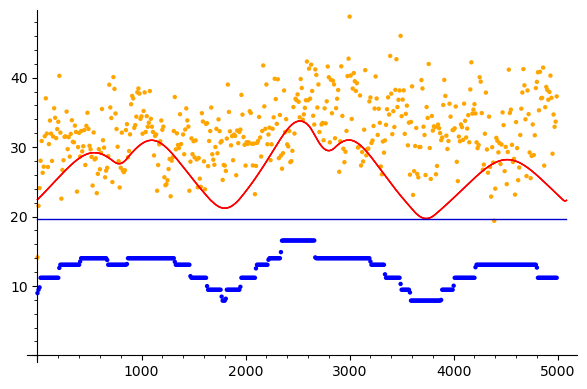

In [60]:
import numpy as np
s_data = np.array(sim.serverAppStats[1:-2])/1e6# / np.array(sim.clientAppStats[1:-2]) * 40
c_data = np.array(sim.clientAppStats[1:-2])/1e6# / np.array(sim.clientAppStats[1:-2]) * 40
list_plot([(i * 10, sum(s_data[i])) for i in range(len(s_data))]) + \
list_plot([(i * 10, sum(c_data[i])) for i in range(len(c_data))], color='orange') + \
thruPlot

In [34]:
# Looks like overflowed packets are dropped, but we'd have windowing issues just doing this :/
import numpy as np
np.array(sim.serverAppStats[1:-2]) / np.array(sim.clientAppStats[1:-2])

array([[0.58772373],
       [0.44018909],
       [0.41045881],
       [0.42244592],
       [0.52313731],
       [0.41993256]])

In [ ]:
q=flh.GetMonitor()
print(q.SerializeToXmlString(2, True, False))

In [70]:
cnt = {}
for i in ns.core.Simulator.getCounts():
    n, t = i.split(':')
    cnt[n] = t

for i in ns.core.Simulator.getTiming():
    n, t = i.split(':')
    if int(t) > 1000:
        # Thing, milliseconds, count, us/execution
        print(i, cnt[n], 1000 * float(t) / float(cnt[n]))
        
        

N3ns33PtrINS_21PointToPointNetDeviceEEE.MN3ns321PointToPointNetDeviceEFvNS_3PtrINS_6PacketEEEE:571961 14377414 39.78191071078568
PFvvE:3639 97 37515.463917525776
PN3ns311FlowMonitorE.MN3ns311FlowMonitorEFvvE:4924 6030 816.5837479270315
PN3ns313TcpSocketBaseE.MN3ns313TcpSocketBaseEFjbE:3069 54682 56.12450166416737
PN3ns314LteSpectrumPhyE.MN3ns314LteSpectrumPhyEFvvE:809519 32405672 24.98078114226423
PN3ns315LteInterferenceE.MN3ns315LteInterferenceEFvNS_3PtrIKNS_13SpectrumValueEEEjE:31309 20083530 1.5589390908869107
PN3ns315PPBPApplicationE.MN3ns315PPBPApplicationEFvvE:232744 11971718 19.441152890504103
PN3ns321PointToPointNetDeviceE.MN3ns321PointToPointNetDeviceEFvvE:6355 14377422 0.4420124831837029
PN3ns325MultiModelSpectrumChannelE.MN3ns325MultiModelSpectrumChannelEFvNS_3PtrINS_24SpectrumSignalParametersEEENS1_INS_11SpectrumPhyEEEE:37204 20083557 1.8524606970767181
PN3ns326RadioBearerStatsCalculatorE.MN3ns326RadioBearerStatsCalculatorEFvvE:1759 24041 73.16667359926792
PN3ns38LteUePhyE.

In [73]:
import sys
sys.version

'3.8.5 (default, Jul 28 2020, 12:59:40) \n[GCC 9.3.0]'